source material: https://www.kaggle.com/nicohrubec/pytorch-multilabel-neural-network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import os
from datetime import datetime

## Load Data

In [2]:
BASE_PATH = os.environ.get('TRAINML_DATA_PATH') if os.environ.get('TRAINML_DATA_PATH') else '../input/lish-moa'
BASE_PATH

'/opt/data'

In [3]:
train_features = pd.read_csv(f'{BASE_PATH}/train_features.csv')
train_targets = pd.read_csv(f'{BASE_PATH}/train_targets_scored.csv')
test_features = pd.read_csv(f'{BASE_PATH}/test_features.csv')

sample_submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

In [4]:
train_features

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [5]:
train_targets

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Preprocess Data

In [6]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    del df['sig_id']
    return df

train_data = preprocess(train_features)
test_data = preprocess(test_features)

del train_targets['sig_id']

train_targets = train_targets.loc[train_data['cp_type']==0].reset_index(drop=True)
train_data = train_data.loc[train_data['cp_type']==0].reset_index(drop=True)

X = train_data.values
Y = train_targets.values
X_test = test_data.values

In [7]:
X

array([[ 0.    , 24.    ,  0.    , ...,  0.2139,  0.3801,  0.4176],
       [ 0.    , 72.    ,  0.    , ...,  0.1241,  0.6077,  0.7371],
       [ 0.    , 48.    ,  0.    , ..., -0.2187, -1.408 ,  0.6931],
       ...,
       [ 0.    , 24.    ,  1.    , ..., -0.1224, -0.2715,  0.3689],
       [ 0.    , 24.    ,  0.    , ...,  0.7015, -0.629 ,  0.074 ],
       [ 0.    , 72.    ,  0.    , ..., -0.4775, -2.15  , -4.252 ]])

In [8]:
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
X_test

array([[ 0.000e+00,  2.400e+01,  0.000e+00, ..., -5.020e-02,  1.510e-01,
        -7.750e-01],
       [ 0.000e+00,  7.200e+01,  0.000e+00, ..., -4.764e-01, -1.381e+00,
        -7.300e-01],
       [ 1.000e+00,  2.400e+01,  0.000e+00, ...,  1.016e+00,  4.924e-01,
        -1.942e-01],
       ...,
       [ 0.000e+00,  7.200e+01,  0.000e+00, ...,  5.888e-01, -4.205e-01,
        -1.504e-01],
       [ 0.000e+00,  4.800e+01,  1.000e+00, ...,  5.074e-01,  7.430e-01,
        -4.840e-02],
       [ 0.000e+00,  7.200e+01,  0.000e+00, ...,  7.570e-02, -1.356e-01,
         5.280e-01]])

## Create DataLoaders

In [10]:
class MoaDataset(Dataset):
    def __init__(self, features, targets, mode='train'):
        self.mode = mode
        self.data = features
        if mode=='train':
            self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return torch.FloatTensor(self.data[idx]), torch.FloatTensor(self.targets[idx])
        elif self.mode == 'eval':
            return torch.FloatTensor(self.data[idx]), 0

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.33)

In [12]:
train_dataset = MoaDataset(X_train, y_train)
val_dataset = MoaDataset(X_val, y_val)
test_dataset = MoaDataset(X_test, None, mode='eval')

In [13]:
batch_size = 4096
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Define Model

In [14]:
class MoaModel(nn.Module):
    def __init__(self, num_columns):
        super(MoaModel, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_columns)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_columns, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, X):
        X = self.batch_norm1(X)
        X = self.dropout1(X)
        X = F.relu(self.dense1(X))
        
        X = self.batch_norm2(X)
        X = self.dropout2(X)
        X = F.relu(self.dense2(X))
        
        X = self.batch_norm3(X)
        X = self.dropout3(X)
        X = torch.sigmoid(self.dense3(X))
        
        return X

In [32]:
def batch_gd(model, criterion, optimizer, train_loader, val_loader, epochs):
  train_losses = np.zeros(epochs)
  val_losses = np.zeros(epochs)
  for it in range(epochs):
    t0 = datetime.now()
    
    model.train()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item() / len(train_loader))
    
    train_loss = np.mean(train_loss)

    model.eval()
    val_loss = []
    for inputs, targets in val_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      val_loss.append(loss.item() / len(val_loader))
    val_loss = np.mean(val_loss)

    train_losses[it] = train_loss
    val_losses[it] = val_loss

    dt = datetime.now() - t0
    print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration {dt}")

  return train_losses, val_losses

## Instantiate Model

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
model = MoaModel(train_data.shape[1])
model.to(device)

MoaModel(
  (batch_norm1): BatchNorm1d(875, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=875, out_features=2048, bias=True)
  (batch_norm2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=2048, out_features=1048, bias=True)
  (batch_norm3): BatchNorm1d(1048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=1048, out_features=206, bias=True)
)

In [35]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

## Run Training 

In [36]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, val_loader, 50)

Epoch 1/50, Train Loss: 0.1870, Validation Loss: 0.3647, Duration 0:00:00.615799
Epoch 2/50, Train Loss: 0.1802, Validation Loss: 0.3506, Duration 0:00:00.594556
Epoch 3/50, Train Loss: 0.1776, Validation Loss: 0.3447, Duration 0:00:00.517748
Epoch 4/50, Train Loss: 0.1755, Validation Loss: 0.3373, Duration 0:00:00.618606
Epoch 5/50, Train Loss: 0.1716, Validation Loss: 0.3247, Duration 0:00:00.589045
Epoch 6/50, Train Loss: 0.1665, Validation Loss: 0.3105, Duration 0:00:00.589430
Epoch 7/50, Train Loss: 0.1603, Validation Loss: 0.2969, Duration 0:00:00.588694
Epoch 8/50, Train Loss: 0.1522, Validation Loss: 0.2802, Duration 0:00:00.518920
Epoch 9/50, Train Loss: 0.1424, Validation Loss: 0.2602, Duration 0:00:00.600598
Epoch 10/50, Train Loss: 0.1314, Validation Loss: 0.2385, Duration 0:00:00.589076
Epoch 11/50, Train Loss: 0.1195, Validation Loss: 0.2162, Duration 0:00:00.589629
Epoch 12/50, Train Loss: 0.1073, Validation Loss: 0.1895, Duration 0:00:00.518501
Epoch 13/50, Train Loss: 

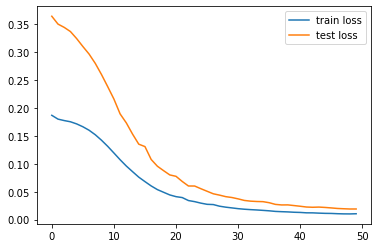

In [37]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

## Test Accuracy

In [38]:
def predict(model, test_loader):
    model.eval()
    preds = []
    
    for inputs, _ in test_loader:
        inputs = inputs.to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [39]:
preds = predict(model, test_loader)

In [41]:
preds

array([[0.02479033, 0.02448333, 0.02440468, ..., 0.02429675, 0.02458981,
        0.02612645],
       [0.02620283, 0.02601224, 0.02650359, ..., 0.02601493, 0.02675914,
        0.02818297],
       [0.0104325 , 0.00928143, 0.00973123, ..., 0.00948484, 0.00948824,
        0.00999806],
       ...,
       [0.0241422 , 0.02337634, 0.02410814, ..., 0.02374226, 0.02440455,
        0.02556291],
       [0.02571984, 0.02526503, 0.02540918, ..., 0.02572037, 0.02561725,
        0.0270779 ],
       [0.02457236, 0.02424092, 0.02448655, ..., 0.02438006, 0.02474346,
        0.026087  ]], dtype=float32)

## Create Submission

In [50]:
targets = [col for col in train_targets.columns]
sample_submission[targets] = preds
sample_submission.loc[test_features['cp_type']=='ctl_vehicle', targets] = 0
sample_submission.to_csv('submission.csv', index=False)

In [51]:
sample_submission

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.024790,0.024483,0.024405,0.026103,0.028710,0.024767,0.025516,0.026518,0.024287,...,0.025557,0.025959,0.022953,0.029317,0.024453,0.026817,0.026760,0.024297,0.024590,0.026126
1,id_001897cda,0.026203,0.026012,0.026504,0.025877,0.028017,0.027372,0.027185,0.028379,0.026214,...,0.027650,0.027721,0.024316,0.029529,0.027160,0.028929,0.028806,0.026015,0.026759,0.028183
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.026220,0.026083,0.026519,0.026025,0.027427,0.026988,0.027209,0.028106,0.026321,...,0.027728,0.028009,0.024750,0.039367,0.027582,0.028995,0.029438,0.026227,0.026909,0.028319
4,id_0027f1083,0.025064,0.023851,0.024688,0.027649,0.029717,0.024900,0.026066,0.025812,0.024075,...,0.025746,0.025211,0.022678,0.020271,0.022299,0.026357,0.022074,0.024546,0.024911,0.026267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,0.025889,0.025926,0.025621,0.026100,0.026826,0.025911,0.026206,0.027623,0.025821,...,0.026807,0.027848,0.024134,0.045978,0.027195,0.028468,0.031158,0.025393,0.025732,0.027510
3978,id_ff925dd0d,0.024831,0.023817,0.024079,0.026960,0.031995,0.024586,0.025901,0.025996,0.023619,...,0.025133,0.024778,0.022242,0.016815,0.021938,0.025982,0.021916,0.024063,0.024291,0.025582
3979,id_ffb710450,0.024142,0.023376,0.024108,0.025202,0.029288,0.025249,0.025419,0.025891,0.023501,...,0.025126,0.024646,0.021856,0.018575,0.022820,0.025969,0.022374,0.023742,0.024405,0.025563
3980,id_ffbb869f2,0.025720,0.025265,0.025409,0.027058,0.030335,0.024862,0.027053,0.026874,0.025266,...,0.026513,0.027172,0.024418,0.034518,0.025340,0.027441,0.026471,0.025720,0.025617,0.027078


In [52]:
sample_submission_summary = sample_submission[sample_submission.columns[~sample_submission.columns.isin(['sig_id'])]].T.agg(['sum','count'], axis='columns').sort_values(by=['sum'])
sample_submission_summary

,sum,count
neuropeptide_receptor_antagonist,82.452950,3982.0
ppar_receptor_antagonist,83.338545,3982.0
trpv_antagonist,83.508734,3982.0
monopolar_spindle_1_kinase_inhibitor,85.337615,3982.0
cholinergic_receptor_antagonist,85.541539,3982.0
...,...,...
dopamine_receptor_antagonist,114.058512,3982.0
cdk_inhibitor,118.585020,3982.0
tubulin_inhibitor,120.738788,3982.0
proteasome_inhibitor,221.500491,3982.0
